# E_AI 07a CIFAR-10


---

CIFAR-10 이미지 데이터셋은 50,000개의 훈련 데이터와 

10,000개의 시험 데이터로 이루어져 있습니다.

제시된 SimpleCNN 모델을 수정하여 성능을 향상시켜보고

시험 데이터에 대한 예측값을 Kaggle에 csv파일로 제출하세요.

Kaggle submit: https://www.kaggle.com/t/eea9ccc5de0e41e49bdc50d0a45a40b2

---

> 학번: 2019452068
>
> 이름: 박규선



### Import packages
---

In [0]:
# MNIST와 달리 channel 이 3개라는 것

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T


### Setup a device

In [125]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Hyperparameters
---


In [0]:
batch_size = 300 #1000
learning_rate = 0.001 #0.02
num_epochs = 15 #10

### Load dataset
---

In [147]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

transform = T.Compose( [T.ToTensor(), 
                        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] )

# CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10('./cifar10_data', 
                                             train=True, download=True, 
                                             transform=transform )
test_dataset = torchvision.datasets.CIFAR10('./cifar10_data', 
                                            train=False, download=True, 
                                            transform=transform )

# Data loader
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [148]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preview the data 
---

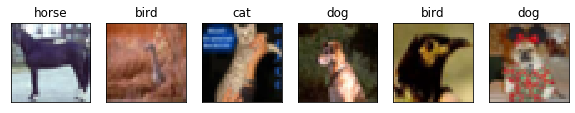

In [149]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images[:6]
labels = labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(10,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Progress monitor
---

In [0]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Define a model
---


In [0]:

class SimpleConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.layer1 = nn.Sequential(
            # Nx3x32x32  (32 - 3 + 2) / 1 + 1 = 32
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            # Nx32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Nx32x32x32  (32 - 3 + 2) / 1 + 1 = 32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # Nx64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Nx64x32x32 (32 - 5 + 0) / 3 + 1 = 10
            nn.Conv2d(64, 128, kernel_size=5, stride=3, padding=0),
            # Nx128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Nx128x16x16 (10 - 5 + 2) / 1 + 1 = 8
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=1),
            # Nx256x8x8
            nn.BatchNorm2d(256),
            nn.ReLU(),

            )
        
        self.fc = nn.Sequential(
            # Nx256x8x8
            nn.Linear(256*8*8, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, num_classes),
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


### Instantiate the model
---

In [152]:
model = SimpleConvNet()

model.to(device)


SimpleConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(3, 3))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=16384, out_features=500, bias=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=10, bias=Tr

In [0]:
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### Train/test
---

In [0]:
def train(loss_list):
    # train phase
    model.train()
    
    # create a progress bar
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # Move the training data to the GPU
        batch, target = batch.to(device), target.to(device)

        # forward propagation
        output = model( batch )

        # calculate the loss
        loss = loss_func( output, target )
        
        # clear previous gradient computation
        optimizer.zero_grad()
 
        # backpropagate to compute gradients
        loss.backward()
 
        # update model weights
        optimizer.step()

        # save loss value
        loss_list.append(loss.item())

        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )
        

In [0]:
def test():
    # test phase
    model.eval()

    correct = 0

    pred_list = []
    
    # We don't need gradients for test, so wrap in 
    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
            # Move the training batch to the GPU
            batch, target = batch.to(device), target.to(device)

            # forward propagation
            output = model( batch )

            # get prediction
            output = torch.argmax(output, 1)

            # accumulate correct number
            correct += (output == target).sum().item()

            pred_list.extend(output.tolist())

    # Calculate test accuracy    
    acc = 100 * float(correct) / len(test_dataset) 
    print( 'Test accuracy: {}/{} ({:.2f}%)'.format( 
        correct, len(test_dataset), acc ) )  

    return pred_list

In [156]:
loss_list = []

for epoch in range(num_epochs):
    
    train(loss_list)
    test()

Loss: 1.1383 50000 / 50000,50000


Test accuracy: 6753/10000 (67.53%)


Loss: 0.6828 50000 / 50000,50000


Test accuracy: 7329/10000 (73.29%)


Loss: 0.4869 50000 / 50000,50000


Test accuracy: 7531/10000 (75.31%)


Loss: 0.3256 50000 / 50000,50000


Test accuracy: 7639/10000 (76.39%)


Loss: 0.1816 50000 / 50000,50000


Test accuracy: 7819/10000 (78.19%)


Loss: 0.0854 50000 / 50000,50000


Test accuracy: 7739/10000 (77.39%)


Loss: 0.0399 50000 / 50000,50000


Test accuracy: 7954/10000 (79.54%)


Loss: 0.0172 50000 / 50000,50000


Test accuracy: 8110/10000 (81.10%)


Loss: 0.0064 50000 / 50000,50000


Test accuracy: 8179/10000 (81.79%)


Loss: 0.0019 50000 / 50000,50000


Test accuracy: 8207/10000 (82.07%)


Loss: 0.0011 50000 / 50000,50000


Test accuracy: 8240/10000 (82.40%)


Loss: 0.0006 50000 / 50000,50000


Test accuracy: 8250/10000 (82.50%)


Loss: 0.0004 50000 / 50000,50000


Test accuracy: 8260/10000 (82.60%)


Loss: 0.0003 50000 / 50000,50000


Test accuracy: 8275/10000 (82.75%)


Loss: 0.0003 50000 / 50000,50000


Test accuracy: 8256/10000 (82.56%)


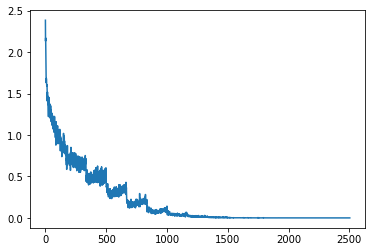

In [157]:
plt.plot(loss_list)

### Make a CSV for submission
---

In [158]:
import csv

def make_pred_csv(model):

    pred_list = test()

    print(len(pred_list))

    with open('cifar10_submit.csv', mode='w') as pred_file:
    
        pred_writer = csv.writer(pred_file, delimiter=',')

        pred_writer.writerow(['id', 'label'])

        for i, label in enumerate(pred_list):
            pred_writer.writerow([i+1, classes[label]])
    

make_pred_csv(model)

Test accuracy: 8256/10000 (82.56%)
10000
